In [1]:
import os
import numpy as np
# import efficientnet.tfkeras

from vit_keras import vit, utils
from tensorflow.keras.models import load_model
# validation
import pandas as pd

2023-03-16 17:07:27.178934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 17:07:27.270907: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 17:07:27.677301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/vit-tf/lib/
2023-03-16 17:07:27.677351: W tensorflow/com

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## load model

> *500 Epoch*

In [4]:
#load model  #ValueError: Unknown layer: 'Custom>ClassToken'
from tensorflow.keras.models import load_model

model_dir = '/media/SSD/rheology2023/VitModel/Regression/tensorflow/Exp-3/R1/models/modelRegress_ViT_l32_Rheology_R1.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]
# # model = tf.keras.models.load_model(
# #     model_dir,
# #     custom_objects={'Custom>ClassToken':tf.keras.models.Model, 'Custom>AddPositionEmbs':tf.keras.models.Model})
# # model.summary()
print(f"height: {height}, width: {width}")

2023-03-16 17:07:32.668146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 17:07:33.103239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8033 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


height: 224, width: 224


In [5]:
model.summary()

Model: "Vit_Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape (Reshape)           (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None)

## Evaluation model

In [6]:
###** Test set

dataframe = pd.read_csv('/home/kannika/codes_AI/Rheology2023/MSDT_datatest.csv')
print(dataframe.shape)
dataframe.head(5)

(870, 8)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test
3,3,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,125,4.45,test
4,4,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,19,0.63,test


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
valid_datagen = ImageDataGenerator(rescale=1./255)

val_generator = valid_datagen.flow_from_dataframe(
                dataframe = dataframe,
                directory = None,
                x_col = 'pathimg',
                y_col = 'MSDT',
                target_size = (height, width),
                batch_size=BATCH_SIZE,
                color_mode= 'rgb',
                class_mode='raw')

Found 870 validated image filenames.


In [8]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
#prob_list = list()
img_path=dataframe['pathimg'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    pred_list.append(predict[0])
    print(predict)

2023-03-16 17:08:01.340491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-16 17:08:01.716926: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 17:08:01.717758: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 17:08:01.717776: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-16 17:08:01.718617: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 17:08:01.718657: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 5s 5s/step
[8.262804]
1/1 [==============================] - 0s 64ms/step
[0.75134426]
1/1 [==============================] - 0s 66ms/step
[0.29029882]
1/1 [==============================] - 0s 69ms/step
[6.7379947]
1/1 [==============================] - 0s 68ms/step
[0.40860102]
1/1 [==============================] - 0s 66ms/step
[2.5248783]
1/1 [==============================] - 0s 68ms/step
[20.715302]
1/1 [==============================] - 0s 64ms/step
[36.448376]
1/1 [==============================] - 0s 73ms/step
[61.40844]
1/1 [==============================] - 0s 63ms/step
[0.26398987]
1/1 [==============================] - 0s 66ms/step
[22.817202]
1/1 [==============================] - 0s 68ms/step
[3.013108]
1/1 [==============================] - 0s 64ms/step
[12.73748]
1/1 [==============================] - 0s 69ms/step
[0.38015246]
1/1 [==============================] - 0s 62ms/step
[1.0791154]
1/1 [==============================] - 0s

[0.966466]
1/1 [==============================] - 0s 64ms/step
[0.6024411]
1/1 [==============================] - 0s 61ms/step
[11.204054]
1/1 [==============================] - 0s 61ms/step
[1.0402251]
1/1 [==============================] - 0s 64ms/step
[8.3538]
1/1 [==============================] - 0s 62ms/step
[0.32987595]
1/1 [==============================] - 0s 89ms/step
[15.818302]
1/1 [==============================] - 0s 89ms/step
[4.749932]
1/1 [==============================] - 0s 62ms/step
[17.334887]
1/1 [==============================] - 0s 59ms/step
[1.8019218]
1/1 [==============================] - 0s 62ms/step
[0.36732513]
1/1 [==============================] - 0s 60ms/step
[0.39685166]
1/1 [==============================] - 0s 94ms/step
[39.417675]
1/1 [==============================] - 0s 80ms/step
[0.2918683]
1/1 [==============================] - 0s 67ms/step
[0.38458896]
1/1 [==============================] - 0s 74ms/step
[0.22355945]
1/1 [=======================

[0.04626658]
1/1 [==============================] - 0s 68ms/step
[1.3715852]
1/1 [==============================] - 0s 83ms/step
[6.7718387]
1/1 [==============================] - 0s 64ms/step
[12.967111]
1/1 [==============================] - 0s 71ms/step
[0.11316963]
1/1 [==============================] - 0s 68ms/step
[0.50895053]
1/1 [==============================] - 0s 68ms/step
[0.82995886]
1/1 [==============================] - 0s 72ms/step
[4.2827353]
1/1 [==============================] - 0s 75ms/step
[0.17865627]
1/1 [==============================] - 0s 61ms/step
[2.3402042]
1/1 [==============================] - 0s 62ms/step
[0.61184883]
1/1 [==============================] - 0s 69ms/step
[0.10005676]
1/1 [==============================] - 0s 68ms/step
[46.255062]
1/1 [==============================] - 0s 65ms/step
[0.5906001]
1/1 [==============================] - 0s 66ms/step
[24.236866]
1/1 [==============================] - 0s 69ms/step
[0.8284988]
1/1 [================

1/1 [==============================] - 0s 65ms/step
[9.027687]
1/1 [==============================] - 0s 57ms/step
[15.9401045]
1/1 [==============================] - 0s 60ms/step
[7.95621]
1/1 [==============================] - 0s 62ms/step
[0.44935676]
1/1 [==============================] - 0s 69ms/step
[14.009718]
1/1 [==============================] - 0s 66ms/step
[0.24092665]
1/1 [==============================] - 0s 66ms/step
[0.23090832]
1/1 [==============================] - 0s 68ms/step
[26.129053]
1/1 [==============================] - 0s 67ms/step
[9.368554]
1/1 [==============================] - 0s 67ms/step
[0.26722455]
1/1 [==============================] - 0s 66ms/step
[0.49150565]
1/1 [==============================] - 0s 65ms/step
[0.24729924]
1/1 [==============================] - 0s 67ms/step
[1.0137371]
1/1 [==============================] - 0s 62ms/step
[0.21162839]
1/1 [==============================] - 0s 69ms/step
[19.061872]
1/1 [==============================]

[20.400543]
1/1 [==============================] - 0s 61ms/step
[2.1448963]
1/1 [==============================] - 0s 65ms/step
[0.19655819]
1/1 [==============================] - 0s 67ms/step
[0.21207027]
1/1 [==============================] - 0s 71ms/step
[0.19377391]
1/1 [==============================] - 0s 69ms/step
[1.920165]
1/1 [==============================] - 0s 66ms/step
[11.693537]
1/1 [==============================] - 0s 78ms/step
[3.6466174]
1/1 [==============================] - 0s 65ms/step
[0.6759505]
1/1 [==============================] - 0s 62ms/step
[0.33632442]
1/1 [==============================] - 0s 63ms/step
[0.8025883]
1/1 [==============================] - 0s 67ms/step
[16.303257]
1/1 [==============================] - 0s 62ms/step
[0.47526646]
1/1 [==============================] - 0s 69ms/step
[0.40049028]
1/1 [==============================] - 0s 71ms/step
[0.21453077]
1/1 [==============================] - 0s 61ms/step
[1.4197879]
1/1 [=================

1/1 [==============================] - 0s 61ms/step
[0.6230343]
1/1 [==============================] - 0s 63ms/step
[1.3126276]
1/1 [==============================] - 0s 63ms/step
[0.06638787]
1/1 [==============================] - 0s 62ms/step
[0.27332288]
1/1 [==============================] - 0s 65ms/step
[0.05149656]
1/1 [==============================] - 0s 69ms/step
[0.04051715]
1/1 [==============================] - 0s 68ms/step
[0.04846226]
1/1 [==============================] - 0s 66ms/step
[0.19064236]
1/1 [==============================] - 0s 65ms/step
[0.2143544]
1/1 [==============================] - 0s 68ms/step
[0.8841664]
1/1 [==============================] - 0s 70ms/step
[0.3202658]
1/1 [==============================] - 0s 66ms/step
[1.682073]
1/1 [==============================] - 0s 65ms/step
[1.8861042]
1/1 [==============================] - 0s 60ms/step
[7.6891103]
1/1 [==============================] - 0s 65ms/step
[3.7323453]
1/1 [==============================

1/1 [==============================] - 0s 68ms/step
[0.92508507]
1/1 [==============================] - 0s 69ms/step
[0.1102107]
1/1 [==============================] - 0s 68ms/step
[0.51099557]
1/1 [==============================] - 0s 68ms/step
[0.164531]
1/1 [==============================] - 0s 66ms/step
[0.14019707]
1/1 [==============================] - 0s 68ms/step
[0.46456754]
1/1 [==============================] - 0s 61ms/step
[0.30263686]
1/1 [==============================] - 0s 62ms/step
[0.34684238]
1/1 [==============================] - 0s 66ms/step
[0.18031268]
1/1 [==============================] - 0s 69ms/step
[0.142521]
1/1 [==============================] - 0s 71ms/step
[1.023969]
1/1 [==============================] - 0s 65ms/step
[0.16304305]
1/1 [==============================] - 0s 60ms/step
[0.20232832]
1/1 [==============================] - 0s 64ms/step
[0.1452787]
1/1 [==============================] - 0s 65ms/step
[0.15364034]
1/1 [============================

In [9]:
pred_list

[8.262804,
 0.75134426,
 0.29029882,
 6.7379947,
 0.40860102,
 2.5248783,
 20.715302,
 36.448376,
 61.40844,
 0.26398987,
 22.817202,
 3.013108,
 12.73748,
 0.38015246,
 1.0791154,
 0.24668886,
 34.72052,
 0.17179726,
 0.29103148,
 43.62102,
 13.473753,
 18.652023,
 0.60424906,
 0.36531603,
 29.009974,
 1.7009811,
 1.3347064,
 5.5605817,
 0.2761145,
 17.438282,
 38.900063,
 2.7733247,
 2.0369568,
 0.11429407,
 0.1478071,
 14.488409,
 13.048963,
 6.314247,
 40.125805,
 0.32332754,
 0.19451976,
 25.987986,
 2.5124748,
 0.004599329,
 0.2336638,
 10.128817,
 0.70279336,
 0.17477149,
 48.995876,
 28.320826,
 0.13371812,
 60.502136,
 2.8055081,
 0.1528276,
 0.5401513,
 0.24242198,
 7.396653,
 0.057621703,
 0.33388308,
 0.76555663,
 5.7408385,
 12.430749,
 40.381382,
 0.2639924,
 32.039368,
 0.1983098,
 0.2577177,
 0.5223906,
 4.7855215,
 2.4410362,
 0.33759698,
 33.293564,
 0.24503794,
 15.568776,
 0.72071975,
 5.7153206,
 0.32489258,
 1.4612675,
 57.366154,
 27.011711,
 0.19054422,
 5.37482

In [10]:
print(len(pred_list))

dataframe['pre_MSDT'] = pred_list
dataframe.head(3)

870


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test,8.262804
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test,0.751344
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test,0.290299


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_test = dataframe['MSDT'].tolist()
# The mean squared error
print("Root Mean squared error: %.4f" % mean_squared_error(y_test, pred_list, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_test, pred_list))
print("Mean absolute error: %.4f" % mean_absolute_error(y_test, pred_list))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, pred_list))

Root Mean squared error: 1.9334
Mean squared error: 3.7382
Mean absolute error: 0.9725
Coefficient of determination: 0.9521


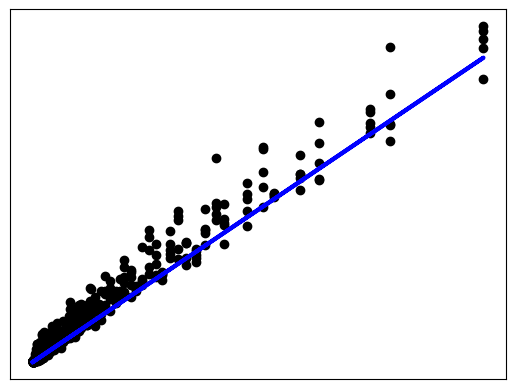

In [12]:
# Plot outputs
plt.scatter(y_test, pred_list, color="black")
plt.plot(y_test, y_test, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Plot : GLY10

> ## t & msd unit

In [13]:
import random

## Set solution
G = 10
_G = f"GLY{G}"

df_idt = pd.read_csv(f'/home/kannika/codes_AI/Rheology2023/MSDT_G{G}.csv')
print(df_idt.shape)
_GLY = dataframe[dataframe['GLY']==_G]
setFolder = list(set(_GLY['folderName']))
rand = random.choices(setFolder, k=1)
rand_ = rand[0]
df_rand = _GLY[_GLY['folderName']==rand_].reset_index(drop=True)
print(df_rand.shape)
df_rand = df_rand.sort_values(by=['idt'])
list_t = df_idt['t'].tolist()
df_rand['t'] = list_t
df_rand.head(3)

(29, 3)
(29, 9)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT,t
22,80,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,1,0.05,test,0.190544,0.052498
7,65,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,2,0.09,test,0.198310,0.091199
14,72,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_204812...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,3,0.14,test,0.245038,0.140551


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_testGLY10 = df_rand['MSDT'].tolist()
pred_listGLY10 = df_rand['pre_MSDT'].tolist()
# The mean squared error
print("========== Predict MSDT จาก Glycerol ความเข้มข้น 10% ==========")
print("Root Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10))
print("Mean absolute error: %.4f" % mean_absolute_error(y_testGLY10, pred_listGLY10))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_testGLY10, pred_listGLY10))
print("-"*80)

========== Predict MSDT จาก Glycerol ความเข้มข้น 10% ==========
Root Mean squared error: 2.7220
Mean squared error: 7.4095
Mean absolute error: 1.6815
Coefficient of determination: 0.9638
--------------------------------------------------------------------------------


In [16]:
#df_idt['dt'].tolist()
lstMSDT = df_rand['MSDT'].tolist() 
lstpre_MSDT = df_rand['pre_MSDT'].tolist() 
print(len(lstMSDT))
print(len(lstpre_MSDT))

29
29


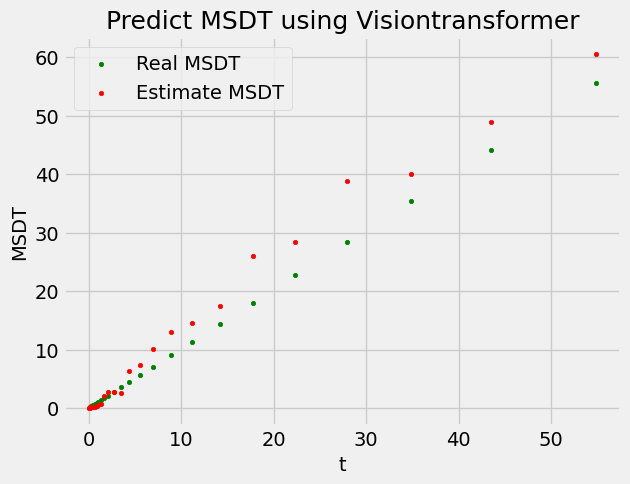

In [17]:
import matplotlib.pyplot as plt
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, lstMSDT,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, lstpre_MSDT,
            color = "red", s = 10, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predict MSDT using Visiontransformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()

In [18]:
print(min(list_t))
print(max(list_t))

0.052498082
54.81658222


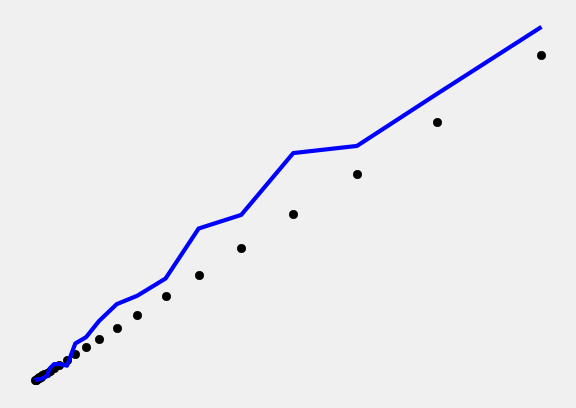

In [19]:
# Plot outputs
plt.scatter(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

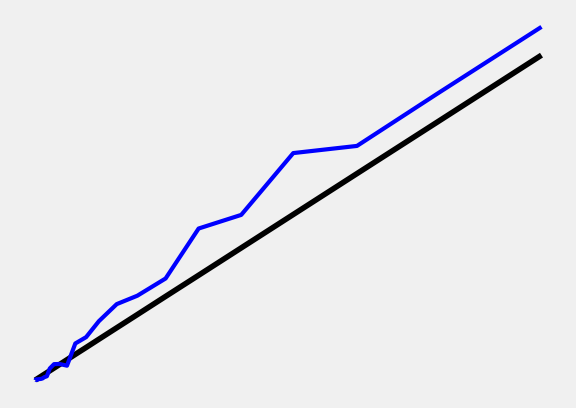

In [20]:
# Plot outputs
plt.plot(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

---------------------------------